In [130]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [131]:
assert pyro.__version__.startswith('0.3.1')
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [132]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    trans = transforms.ToTensor()
    train_set = dset.FashionMNIST(root=root, train=True, transform=trans,
                           download=download)

    test_set = dset.FashionMNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [133]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc31 = nn.Linear( hidden_dim, hidden_dim)
        self.fc41 = nn.Linear( hidden_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784)
        # setup the non-linearities
        self.softplus = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        hidden1 = self.softplus(self.fc31(hidden))
        hidden2 = self.softplus(self.fc41(hidden1))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden2))
        return loc_img

In [134]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Encoder, self).__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc31 = nn.Linear(hidden_dim, hidden_dim) 
        self.fc41 = nn.Linear(hidden_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.ReLU()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        hidden1 = self.softplus(self.fc31(hidden))
        hidden2 = self.softplus(self.fc41(hidden1))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden2)
        z_scale = torch.exp(self.fc22(hidden2))
        return z_loc, z_scale

In [135]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img
    def sample_z(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        
        return z, z_loc, z_scale
    
    def sample_image(self, z):
        # encode image x
        loc_img = self.decoder(z)
        
        return loc_img

In [136]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [137]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [138]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = False

# Run only for a single iteration for testing
NUM_EPOCHS = 1 if smoke_test else 50
TEST_FREQUENCY = 5

In [139]:
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 000]  average training loss: 207.9095
[epoch 000] average test loss: 190.2834
[epoch 001]  average training loss: 177.0931
[epoch 002]  average training loss: 154.1315
[epoch 003]  average training loss: 141.6567
[epoch 004]  average training loss: 136.2380
[epoch 005]  average training loss: 132.2846
[epoch 005] average test loss: 130.2277
[epoch 006]  average training loss: 128.2836
[epoch 007]  average training loss: 124.3201
[epoch 008]  average training loss: 120.6160
[epoch 009]  average training loss: 118.3424
[epoch 010]  average training loss: 116.2591
[epoch 010] average test loss: 115.5108
[epoch 011]  average training loss: 114.5635
[epoch 012]  average training loss: 113.2389
[epoch 013]  average training loss: 112.2593
[epoch 014]  average training loss: 111.4747
[epoch 015]  average training loss: 110.7589
[epoch 015] average test loss: 111.8046
[epoch 016]  average training loss: 110.1290
[epoch 017]  average training loss: 109.4690
[epoch 018]  average training 

In [140]:
#vaeから画像を再構成
from PIL import Image
t=0
for x, _ in test_loader:
    
    if(t%10==0): 
        im = vae.reconstruct_img(x)
        im = (im*255).int()
        im = im.detach().numpy()
        im = im. reshape(256,28,28)
        print(im[0].shape)
        pil_img = Image.fromarray(im[0])
        x = (x*255).int()
        x = x.detach().numpy()
        x = x. reshape(256,28,28)
        print(x[0].shape)
        x = Image.fromarray(x[0])
        x.show()
        pil_img.show()
        pil_img.save('lena_square_save{}.png'.format(t))
    t=t+1


(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)


In [141]:
z_loc1,z_scale1=[],[]
for x, labels in test_loader:
    z, z_loc, z_scale = vae.sample_z(x)
    print(z_loc.size())
    print(z_scale.size())
    z_loc=z_loc.detach().numpy()
    z_scale=z_scale.detach().numpy()
    KLD = (np.sum((pow(z_loc,2)+pow(z_scale,2))/2 -np.log(z_scale) )-0.5*2)/256
    z_loc1.append(z_loc[:,1])
    z_scale1.append(z_loc[:,0])
    
    labels= labels.numpy()
    break
    #im = vae.sample_image(z_loc)
    #print(z.size())
#print(z_loc1)
#print(z_scale1)
print(KLD)
print(labels)

torch.Size([256, 50])
torch.Size([256, 50])
40.434730529785156
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9 6 0 5 4 9 9 2 1 9 4 8
 7 3 9 7 4 4 4 9 2 5 4 7 6 7 9 0 5 8 5 6 6 5 7 8 1 0 1 6 4 6 7 3 1 7 1 8 2
 0 2 9 9 5 5 1 5 6 0 3 4 4 6 5 4 6 5 4 5 1 4 4 7 2 3 2 7 1 8 1 8 1 8 5 0 8
 9 2 5 0 1 1 1 0 9 0 3 1 6 4 2 3 6 1 1 1 3 9 5 2 9 4 5 9 3 9 0 3 6 5 5 7 2
 2 7 1 2 8 4 1 7 3 3 8 8 7 9 2 2 4 1 5 9 8 7 2 3 0 4 4 2 4 1 9 5 7 7]


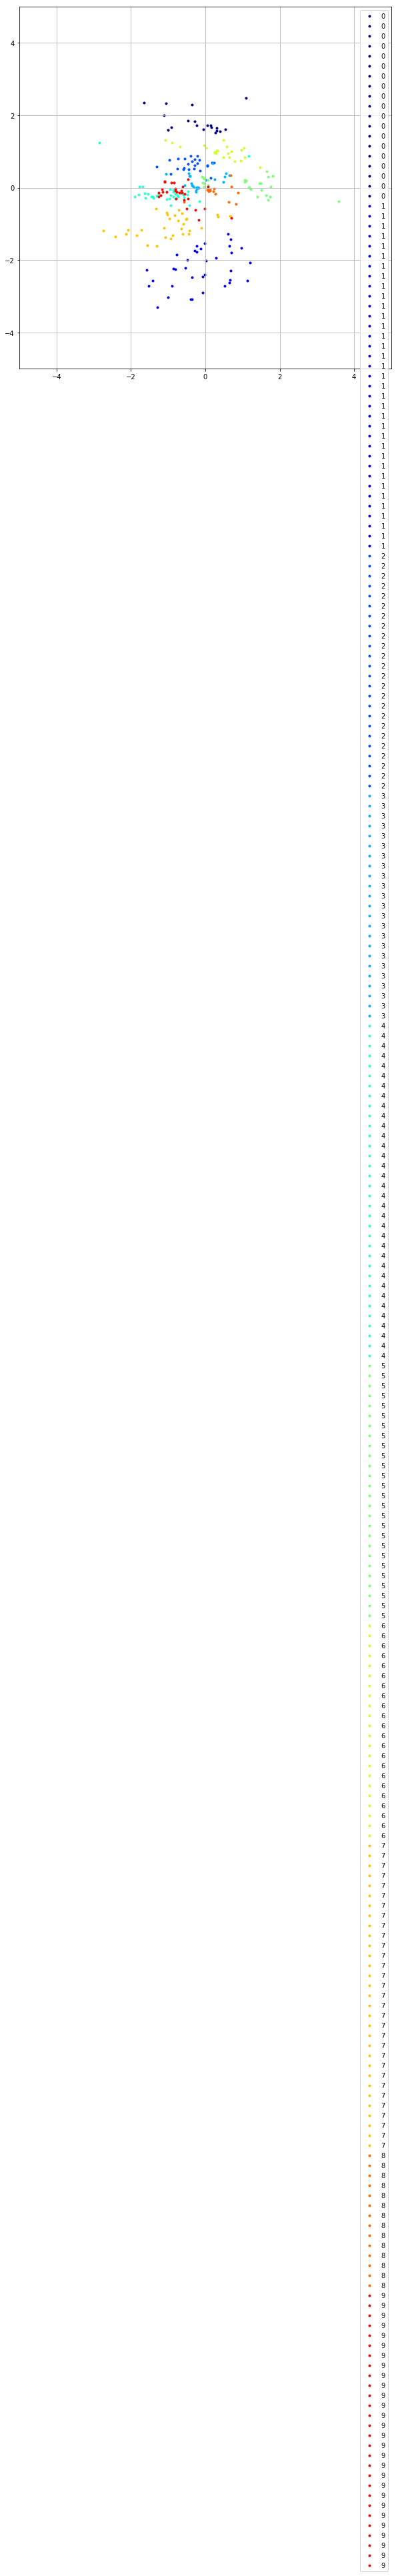

In [125]:
colors = []
cm = plt.get_cmap('jet')
label_name=[]
for i in range(10):
    colors.append(cm(1.*i/10))
    label_name.append(i)
plt.figure(figsize=(10, 10))
for c in range(10):
    for i in range(256):
        if(labels[i] == c):
            plt.scatter(z_loc1[0][i], z_scale1[0][i], marker='.',color=colors[c],label =label_name[c])
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend()
plt.grid()

In [128]:
from PIL import Image
for i in range(5):
    im = vae.sample_image(-1.5*i*torch.ones(16,2))
    im = (im*255).int()
    im = im.detach().numpy()
    im = im. reshape(16,28,28)
    #print(im[3])
    pil_img = Image.fromarray(im[3])
    pil_img.show()

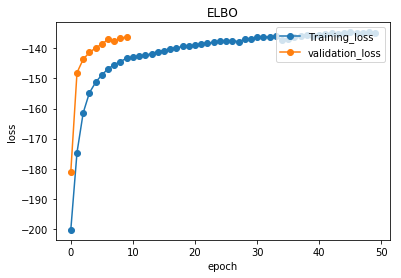

In [108]:
plt.plot(train_elbo,"o-",label="Training_loss") #Training 平均損失
plt.plot(test_elbo,"o-", label="validation_loss")#validation 平均損失
plt.title('ELBO')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()